In [1]:
import underworld as uw
import underworld.function as fn
import glucifer

mesh = uw.mesh.FeMesh_Cartesian(elementRes=(16,16), periodic=(True,False))
velVar = uw.mesh.MeshVariable(mesh,2)
pressVar = uw.mesh.MeshVariable(mesh.subMesh,1)




In [2]:
#Simple shear boundary conditions:
bot_nodes = mesh.specialSets["MinJ_VertexSet"]
top_nodes = mesh.specialSets["MaxJ_VertexSet"]
bc = uw.conditions.DirichletCondition(velVar, (top_nodes+bot_nodes,top_nodes+bot_nodes))
velVar.data[bot_nodes.data] = (-0.5,0.)
velVar.data[top_nodes.data] = ( 0.5,0.)

#Vertically increasing exponential viscosity:
fn_visc = fn.math.exp(12.*fn.coord()[1]+1.)
stokesSys = uw.systems.Stokes(velVar,pressVar,fn_visc,conditions=[bc,])

#Solve:
solver = uw.systems.Solver(stokesSys)
solver.solve()





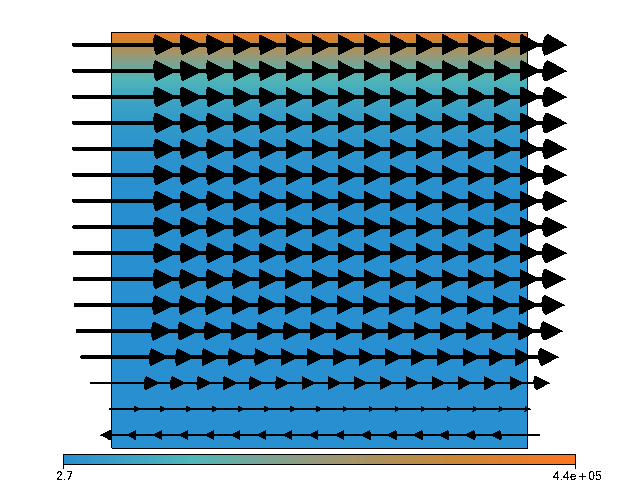

In [3]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, fn_visc ))
fig.append( glucifer.objects.VectorArrows(mesh,velVar, arrowHead=0.2, scaling=0.5))

fig.show()

In [10]:
fn_visc.evaluate(mesh).mean()

49322.577598676442

In [4]:
#Use the min_max function to determine a maximum stress
fn_stress =  2.*fn_visc*uw.function.tensor.symmetric( velVar.fn_gradient )
fn_minmax_inv = fn.view.min_max(fn.tensor.second_invariant(fn_stress))
ignore = fn_minmax_inv.evaluate(mesh)
import numpy as np
np.isclose(fn_minmax_inv.max_global(), 49.2, rtol=1e-03)

True

In [6]:
fn_minmax_inv.max_global()

49.172812156835


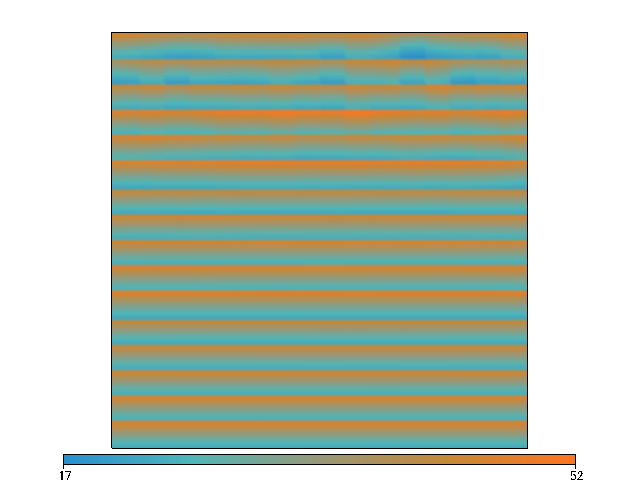

In [5]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, fn.tensor.second_invariant(fn_stress) ))
#fig.append( glucifer.objects.VectorArrows(mesh,velVar, arrowHead=0.2, scaling=0.5))

fig.show()

In [22]:

#Now lets set the limited viscosity. Note that the system is now non-linear.
fn_visc_limited = fn.rheology.stress_limiting_viscosity(fn_stress,30.,fn_visc)
stokesSys.fn_viscosity = fn_visc_limited
solver.solve(nonLinearIterate=True)


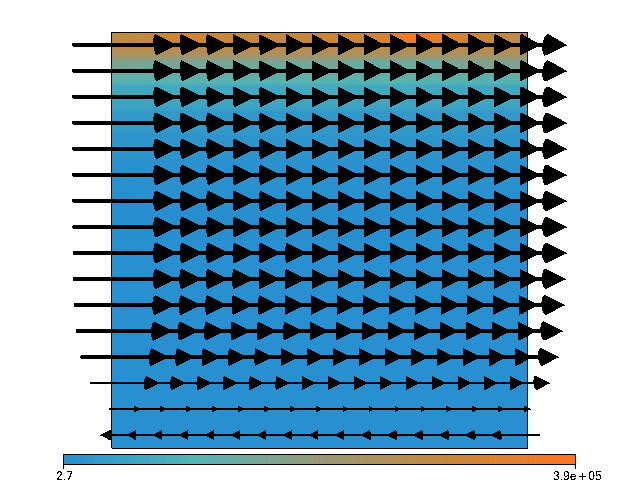

In [23]:
fig = glucifer.Figure()
fig.append( glucifer.objects.Surface(mesh, fn_visc_limited ))
fig.append( glucifer.objects.VectorArrows(mesh,velVar, arrowHead=0.2, scaling=0.5))

fig.show()

In [24]:

#Now check the stress.
fn_stress = 2.*fn_visc_limited*uw.function.tensor.symmetric( velVar.fn_gradient )
fn_minmax_inv = fn.view.min_max(fn.tensor.second_invariant(fn_stress))
ignore = fn_minmax_inv.evaluate(mesh)

In [25]:
np.isclose(fn_minmax_inv.max_global(), 30., rtol=1e-03)

True